<a href="https://colab.research.google.com/github/0cars0903/GAN_WITH_MNIST/blob/main/GAN_WITH_MNIST.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

### Data Loader 생성

In [1]:
import torch
if torch.cuda.is_available() == True:
    device = 'cuda:0'
    print('현재 가상환경 GPU 사용 가능상태')
else:
    device = 'cpu'
    print('GPU 사용 불가능 상태')

현재 가상환경 GPU 사용 가능상태


In [2]:
import torch
import torchvision.transforms as transforms
from torchvision.transforms import ToTensor, Resize, Normalize, RandomHorizontalFlip, RandomCrop
import torchvision.datasets as datasets

batch_size = 100

# MNIST Dataset
transform = transforms.Compose([ToTensor(), Normalize(mean=(0.5,), std=(0.5,))]) # -1 ~ 1 사이로 정규화

train_dataset = datasets.MNIST(root='./', train=True, transform=transform, download=True)
test_dataset = datasets.MNIST(root='./', train=False, transform=transform, download=False)

# Data Loader (Input Pipeline)
train_loader = torch.utils.data.DataLoader(dataset=train_dataset, batch_size=batch_size, shuffle=True)
test_loader = torch.utils.data.DataLoader(dataset=test_dataset, batch_size=batch_size, shuffle=False)

  0%|          | 0/9912422 [00:00<?, ?it/s]

Extracting ./MNIST/raw/train-images-idx3-ubyte.gz to ./MNIST/raw



  0%|          | 0/28881 [00:00<?, ?it/s]

Extracting ./MNIST/raw/train-labels-idx1-ubyte.gz to ./MNIST/raw



  0%|          | 0/1648877 [00:00<?, ?it/s]

Extracting ./MNIST/raw/t10k-images-idx3-ubyte.gz to ./MNIST/raw



  0%|          | 0/4542 [00:00<?, ?it/s]

Extracting ./MNIST/raw/t10k-labels-idx1-ubyte.gz to ./MNIST/raw



### Generator와 Discriminator 모델 아키텍처 설계

In [3]:
import torch.nn as nn
import torch.nn.functional as F

# Generator
class Generator(nn.Module):
    
    def __init__(self, g_input_dim, g_output_dim):
        super(Generator, self).__init__()       
        self.fc1 = nn.Linear(g_input_dim, 256) # 100 -> 256
        self.fc2 = nn.Linear(256, 512) # 256 -> 512
        self.fc3 = nn.Linear(512, 1024) # 512 -> 1024
        self.fc4 = nn.Linear(1024, g_output_dim) # 1024 -> 784
    
    def forward(self, x):
        x = F.leaky_relu(self.fc1(x), 0.2)
        x = F.leaky_relu(self.fc2(x), 0.2)
        x = F.leaky_relu(self.fc3(x), 0.2)
        return torch.tanh(self.fc4(x)) # Tanh : -1 ~ 1 사이로 데이터 생성
    
# Discriminator
class Discriminator(nn.Module):

    def __init__(self, d_input_dim):
        super(Discriminator, self).__init__()
        self.fc1 = nn.Linear(d_input_dim, 1024) # 784 -> 1024
        self.fc2 = nn.Linear(1024, 512) # 1024 -> 512
        self.fc3 = nn.Linear(512, 256) # 512 -> 256
        self.fc4 = nn.Linear(256, 1) # 256 -> 1
    
    def forward(self, x):
        x = F.leaky_relu(self.fc1(x), 0.2)
        x = F.dropout(x, 0.3)
        x = F.leaky_relu(self.fc2(x), 0.2)
        x = F.dropout(x, 0.3)
        x = F.leaky_relu(self.fc3(x), 0.2)
        x = F.dropout(x, 0.3)
        return torch.sigmoid(self.fc4(x))

### 두 모델 G, D 선언

In [4]:
# build network
z_dim = 100
mnist_dim = train_dataset.train_data.size(1) * train_dataset.train_data.size(2) # 28 * 28 = 784

G = Generator(g_input_dim = z_dim, g_output_dim = mnist_dim).to(device)
D = Discriminator(mnist_dim).to(device)

/usr/local/lib/python3.8/dist-packages/torchvision/datasets/mnist.py:75: UserWarning: train_data has been renamed data
  warnings.warn("train_data has been renamed data")


### Optimizer, Loss Function 선언

In [5]:
# loss
criterion = nn.BCELoss()

# optimizer
lr = 0.0002
G_optimizer = torch.optim.Adam(G.parameters(), lr = lr)
D_optimizer = torch.optim.Adam(D.parameters(), lr = lr)

### Generator 학습 알고리즘 제작

In [6]:
# from torch.autograd import Variable

def G_train(x):
    
    G.zero_grad()
    
    z = torch.randn(batch_size, z_dim).to(device) # 100 * 100 행렬을 -1 ~ 1 사이 수로 생성
    y = torch.ones(batch_size, 1).to(device) # 1로 가득찬 y를 생성

    G_output = G(z)
    D_output = D(G_output)
    G_loss = criterion(D_output, y) 

    # 역전파 + 경사하강
    G_loss.backward()
    G_optimizer.step()
        
    return G_loss.data.item()

### Discriminator 학습 알고리즘 제작

In [7]:
def D_train(x):
    
    D.zero_grad()

    x_real = x.view(-1, mnist_dim) # 실제 MNIST 데이터 1장 불러오기
    y_real = torch.ones(batch_size, 1) # 1로 가득찬 100개 리스트 생성(레이블 1 = 진짜)
    
    x_real, y_real = x_real.to(device), y_real.to(device) # gpu

    D_output = D(x_real)
    D_real_loss = criterion(D_output, y_real)

    z = torch.randn(batch_size, z_dim).to(device) # 랜덤 노이즈 생성(100 * 100)
    x_fake, y_fake = G(z), torch.zeros(batch_size, 1).to(device) # 1로 가득찬 100개 리스트 생성

    D_output = D(x_fake)
    D_fake_loss = criterion(D_output, y_fake)

    # 역전파 + 경사하강 시행
    D_loss = D_real_loss + D_fake_loss
    D_loss.backward()
    D_optimizer.step()

    return  D_loss.data.item()

### 1 epoch씩 학습, 10 epoch마다 결과 출력


[1/200]: loss_discre.: 2.52277, loss_gen.: 0.69253
[2/200]: loss_discre.: 3.17869, loss_gen.: 0.54166
[3/200]: loss_discre.: 2.89565, loss_gen.: 0.53496
[4/200]: loss_discre.: 2.62055, loss_gen.: 0.61827
[5/200]: loss_discre.: 2.5816, loss_gen.: 0.55349
[6/200]: loss_discre.: 2.43017, loss_gen.: 0.65989
[7/200]: loss_discre.: 2.42792, loss_gen.: 0.66068
[8/200]: loss_discre.: 2.44736, loss_gen.: 0.65924
[9/200]: loss_discre.: 2.2545, loss_gen.: 0.69901
[10/200]: loss_discre.: 2.36415, loss_gen.: 0.65808


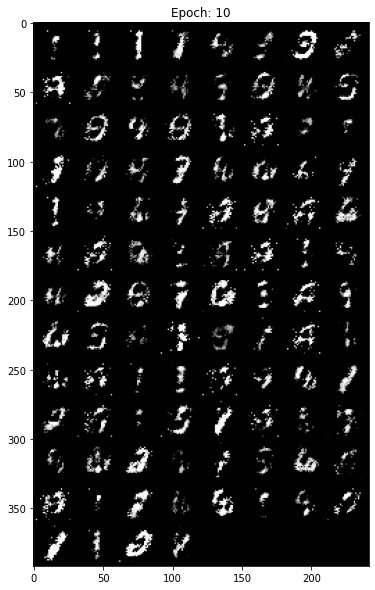

[11/200]: loss_discre.: 2.13871, loss_gen.: 0.73364
[12/200]: loss_discre.: 1.86666, loss_gen.: 0.81783
[13/200]: loss_discre.: 2.13998, loss_gen.: 0.72885
[14/200]: loss_discre.: 1.98705, loss_gen.: 0.77176
[15/200]: loss_discre.: 1.76593, loss_gen.: 0.84493
[16/200]: loss_discre.: 1.77911, loss_gen.: 0.85292
[17/200]: loss_discre.: 1.64321, loss_gen.: 0.90181
[18/200]: loss_discre.: 1.53931, loss_gen.: 0.94855
[19/200]: loss_discre.: 1.57788, loss_gen.: 0.92347
[20/200]: loss_discre.: 1.55984, loss_gen.: 0.93637


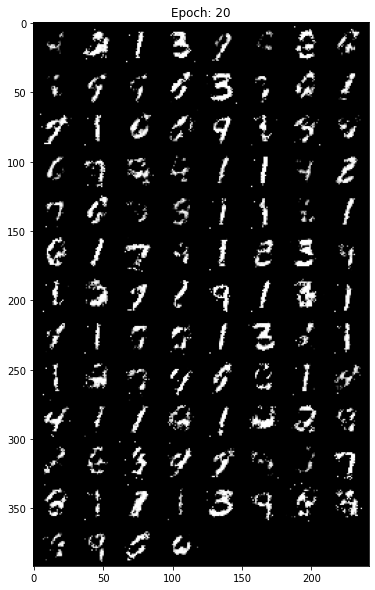

[21/200]: loss_discre.: 1.54503, loss_gen.: 0.94492
[22/200]: loss_discre.: 1.50035, loss_gen.: 0.95685
[23/200]: loss_discre.: 1.42893, loss_gen.: 0.99727
[24/200]: loss_discre.: 1.42283, loss_gen.: 0.99958
[25/200]: loss_discre.: 1.41799, loss_gen.: 0.98862
[26/200]: loss_discre.: 1.36095, loss_gen.: 1.03815
[27/200]: loss_discre.: 1.42821, loss_gen.: 0.99855
[28/200]: loss_discre.: 1.40289, loss_gen.: 1.01203
[29/200]: loss_discre.: 1.41575, loss_gen.: 1.005
[30/200]: loss_discre.: 1.36134, loss_gen.: 1.03091


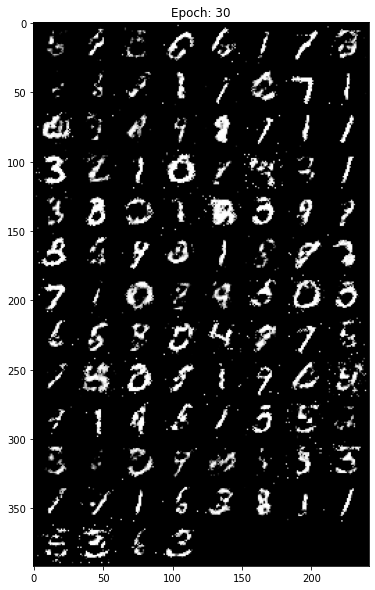

[31/200]: loss_discre.: 1.34004, loss_gen.: 1.04835
[32/200]: loss_discre.: 1.32597, loss_gen.: 1.04028
[33/200]: loss_discre.: 1.25641, loss_gen.: 1.07419
[34/200]: loss_discre.: 1.21265, loss_gen.: 1.09638
[35/200]: loss_discre.: 1.26613, loss_gen.: 1.07273
[36/200]: loss_discre.: 1.25388, loss_gen.: 1.08116
[37/200]: loss_discre.: 1.22115, loss_gen.: 1.08847
[38/200]: loss_discre.: 1.18602, loss_gen.: 1.10184
[39/200]: loss_discre.: 1.16633, loss_gen.: 1.11338
[40/200]: loss_discre.: 1.17261, loss_gen.: 1.11892


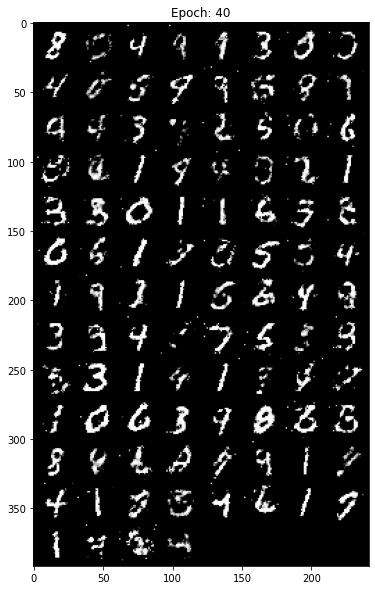

[41/200]: loss_discre.: 1.15727, loss_gen.: 1.12694
[42/200]: loss_discre.: 1.15668, loss_gen.: 1.12267
[43/200]: loss_discre.: 1.14014, loss_gen.: 1.14088
[44/200]: loss_discre.: 1.12197, loss_gen.: 1.1448
[45/200]: loss_discre.: 1.13772, loss_gen.: 1.14034
[46/200]: loss_discre.: 1.11192, loss_gen.: 1.15639
[47/200]: loss_discre.: 1.093, loss_gen.: 1.15808
[48/200]: loss_discre.: 1.07613, loss_gen.: 1.17236
[49/200]: loss_discre.: 1.07777, loss_gen.: 1.17043
[50/200]: loss_discre.: 1.09083, loss_gen.: 1.16377


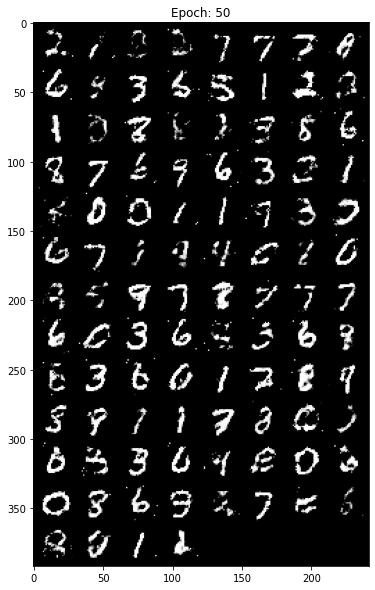

[51/200]: loss_discre.: 1.06386, loss_gen.: 1.17526
[52/200]: loss_discre.: 1.04665, loss_gen.: 1.18156
[53/200]: loss_discre.: 1.05608, loss_gen.: 1.18612
[54/200]: loss_discre.: 1.06497, loss_gen.: 1.18448
[55/200]: loss_discre.: 1.0833, loss_gen.: 1.16945
[56/200]: loss_discre.: 1.04366, loss_gen.: 1.19025
[57/200]: loss_discre.: 1.04157, loss_gen.: 1.18847


KeyboardInterrupt: ignored

In [10]:
from torchvision.utils import save_image
import matplotlib.pyplot as plt
import cv2

n_epoch = 200
cnt = 0
print_time = 10
for epoch in range(1, n_epoch+1):           
    D_losses, G_losses = [], []
    for batch_idx, (x, _) in enumerate(train_loader):
        D_losses.append(D_train(x))
        G_losses.append(G_train(x))

    print_dis_loss = round(float(torch.mean(torch.FloatTensor(G_losses))), 5)
    print_gen_loss = round(float(torch.mean(torch.FloatTensor(D_losses))), 5)
    print('[{}/{}]: loss_discre.: {}, loss_gen.: {}'.format(epoch, n_epoch, print_dis_loss, print_gen_loss))
    if epoch % print_time == 0:
      with torch.no_grad():
          test_z = torch.randn(batch_size, z_dim).to(device)
          generated = G(test_z)
          img_path = './GAN_MNIST' + str(epoch) + '.png'
          save_image(generated.view(generated.size(0), 1, 28, 28), img_path)
          img = cv2.imread(img_path)
          img = cv2.cvtColor(img, cv2.COLOR_RGB2BGR)
          plt.figure(figsize=(10,10))
          plt.imshow(img)
          plt.title('Epoch: {}'.format(epoch))
          plt.show()
    cnt += 1